In [1]:
import math
import json
import numpy as np
import matplotlib.pyplot as plt

import openrtdynamics2.lang as dy
import openrtdynamics2.py_execute as dyexe
from openrtdynamics2.ORTDtoNumpy import ORTDtoNumpy

from vehicle_lib.vehicle_lib import *


In [2]:
# load track data
with open("track_data/simple_track.json", "r") as read_file:
    track_data = json.load(read_file)


# Run a simulation to generate test data

Set-up a simulation of a vehicle (bicycle model). The vehicle is controlled to follow a given path. In addition, an intended lateral distance $\Delta l$ is modulated by applying a pre-defined profile to the reference $\Delta l_r$. 

In [3]:
system = dy.enter_system()

velocity               = dy.system_input( dy.DataTypeFloat64(1), name='velocity_',         default_value=1,      value_range=[0, 25],   title="vehicle velocity")
Delta_l_r              = dy.system_input( dy.DataTypeFloat64(1), name='Delta_l_r',         default_value=0.0,    value_range=[-10, 10], title="lateral deviation to the path")
Delta_l_r_dot          = dy.system_input( dy.DataTypeFloat64(1), name='Delta_l_r_dot',     default_value=0.0,    value_range=[-10, 10], title="1st-order time derivative of lateral deviation to the path")
Delta_l_r_dotdot       = dy.system_input( dy.DataTypeFloat64(1), name='Delta_l_r_dotdot',  default_value=0.0,    value_range=[-10, 10], title="2nd-order time derivative of lateral deviation to the path")


Delta_l_r_dotdot
# parameters
wheelbase = 3.0

# sampling time
Ts = 0.012

# create storage for the reference path:
path = import_path_data(track_data)

# create placeholders for the plant output signals
x       = dy.signal()
y       = dy.signal()
psi     = dy.signal()
psi_dot = dy.signal()




results = path_following_controller_P(
    path,
    x, y, psi, 
    velocity, 
    Delta_l_r=Delta_l_r, 
    Delta_l_r_dot=Delta_l_r_dot,
    Delta_l_r_dotdot=Delta_l_r_dotdot,
    psi_dot=psi_dot,
    velocity_dot=dy.float64(0),
    Ts = Ts,
    k_p = 1
)




#
# The model of the vehicle including a disturbance
#

# steering angle limit
limited_steering = dy.saturate(u=results['delta'], lower_limit=-math.pi/2.0, upper_limit=math.pi/2.0)

# the model of the vehicle
x_, y_, psi_, x_dot, y_dot, psi_dot_ = discrete_time_bicycle_model(limited_steering, velocity, Ts, wheelbase)

# driven distance
d = dy.euler_integrator(velocity, Ts)


# close the feedback loops
x       << x_
y       << y_
psi     << psi_
psi_dot << psi_dot_


#
output_path = {
    'd'   : d,
    'x'   : x,
    'y'   : y,
    'psi' : psi     + results['delta'],
    'K'   : psi_dot + results['delta_dot']
}


#
# outputs: these are available for visualization in the html set-up
#

#dy.append_output(x, 'x')
#dy.append_output(y, 'y')
dy.append_output(psi, 'psi')
dy.append_output(psi_dot, 'psi_dot')

dy.append_output(results['delta'], 'delta')
dy.append_output(results['delta_dot'], 'delta_dot')
dy.append_output(results['x_r'], 'x_r')
dy.append_output(results['y_r'], 'y_r')
dy.append_output(results['psi_r'], 'psi_r')
dy.append_output(results['Delta_l'], 'Delta_l')
dy.append_output(results['d_star'], 'd_star')

dy.append_output(output_path['x'], 'path_x')
dy.append_output(output_path['y'], 'path_y')
dy.append_output(output_path['psi'], 'path_psi')
dy.append_output(output_path['K'], 'path_K')

dy.append_output(velocity*dy.float64(1.0), 'velocity')


dy.append_output(results['line_tracking_internals']['Delta_l_closest_path_sample'], 'Delta_l_closest_path_sample')
dy.append_output(results['line_tracking_internals']['i_star'], 'i_star')
dy.append_output(results['line_tracking_internals']['i_star_2'], 'i_star_2')

dy.append_output(results['line_tracking_internals']['x_s'], 'x_s')
dy.append_output(results['line_tracking_internals']['y_s'], 'y_s')
dy.append_output(results['line_tracking_internals']['x_e'], 'x_e')
dy.append_output(results['line_tracking_internals']['y_e'], 'y_e')

dy.append_output(results['line_tracking_internals']['interpolation_factor'], 'interpolation_factor')


# generate code for Web Assembly (wasm), requires emcc (emscripten) to build
code_gen_results = dy.generate_code(template=dy.TargetWasm(enable_tracing=False), folder="generated/tmp1", build=True)

#
dy.clear()


compiling system tracker_loop (level 1)... 
compiling system simulation (level 0)... 
Generated code will be written to generated/tmp1 .
Running compiler: emcc --bind -s MODULARIZE=1 -s EXPORT_NAME="ORTD_simulator" generated/tmp1/main.cpp -g4 -s -o generated/tmp1/main.js
Compilation result:  32512


In [4]:
compiled_system = dyexe.CompiledCode(code_gen_results)

# define a profile for the lateral distance

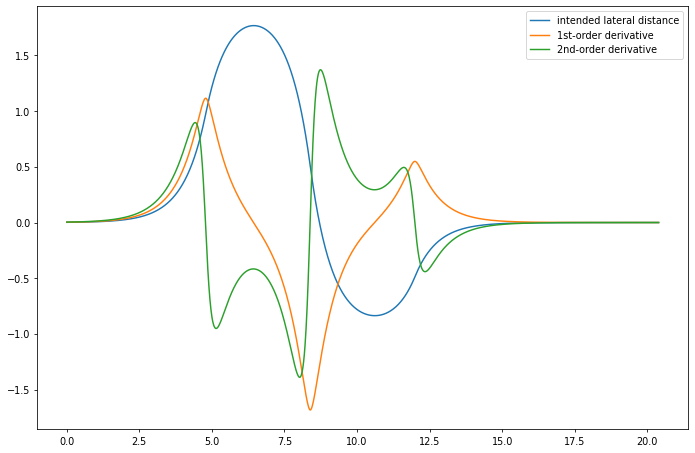

In [5]:

scale = 1

Delta_l_r_profile = filtfilt(Ts, np.concatenate((  np.zeros(400*scale), 2*np.ones(300*scale), -np.ones(300*scale),  np.zeros(700*scale) )), cutoff_frq=0.005 )

Delta_l_r_dot_profile = numerical_derivative(Ts, Delta_l_r_profile)
Delta_l_r_dotdot_profile = numerical_derivative(Ts, Delta_l_r_dot_profile)

time = make_time(Ts, Delta_l_r_profile)
plt.figure(figsize=(12,8), dpi=70)
plt.plot(time, Delta_l_r_profile)
plt.plot(time, Delta_l_r_dot_profile)
plt.plot(time, Delta_l_r_dotdot_profile)
plt.legend(['intended lateral distance', '1st-order derivative', '2nd-order derivative'])
plt.show()

##### 


Run the simulation given parameters to define the steering rates


In [6]:
testsim = dyexe.SystemInstance(compiled_system)

N=len(Delta_l_r_profile)*scale
input_data = {'velocity_': 5.0/scale, 'Delta_l_r': Delta_l_r_profile, 'Delta_l_r_dot': Delta_l_r_dot_profile, 'Delta_l_r_dotdot': Delta_l_r_dotdot_profile}
sim_results = dyexe.run_batch_simulation(testsim, input_data, N )


output_path = {
    'D'   : 0,
    'X'   : sim_results['path_x'],
    'Y'   : sim_results['path_y'],
    'PSI' : sim_results['path_psi'],
    'K'   : sim_results['path_K'],    
}

In [7]:
sim_results['Delta_l_closest_path_sample']

array([-0.01553801, -0.02297656, -0.02360635, ..., -0.01237548,
       -0.02144681, -0.02067784])

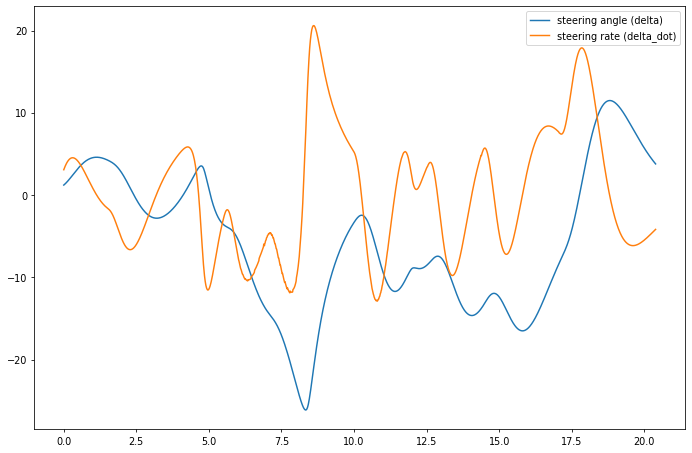

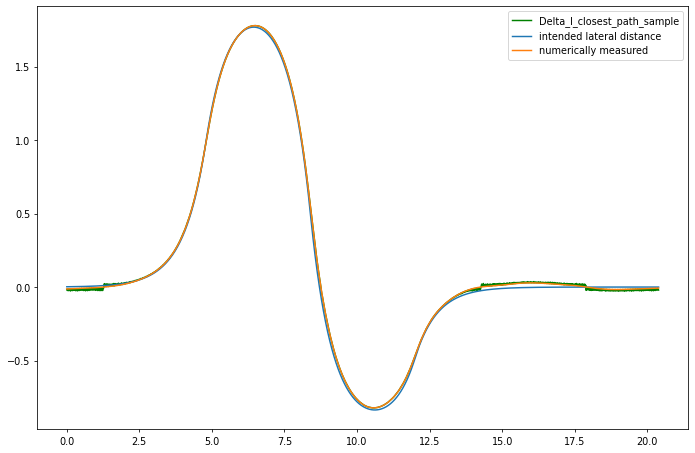

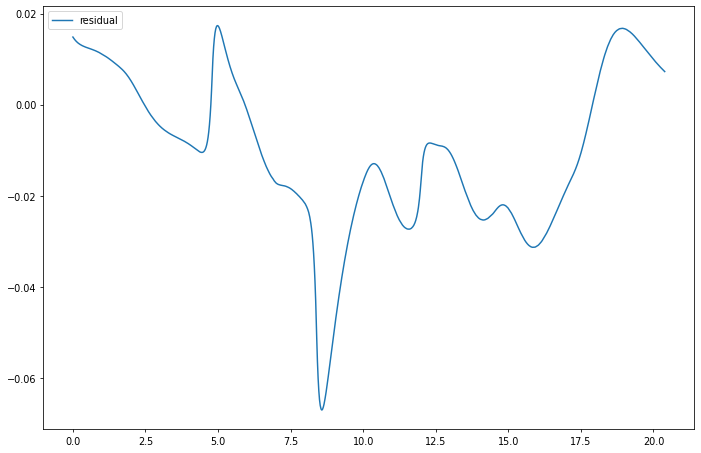

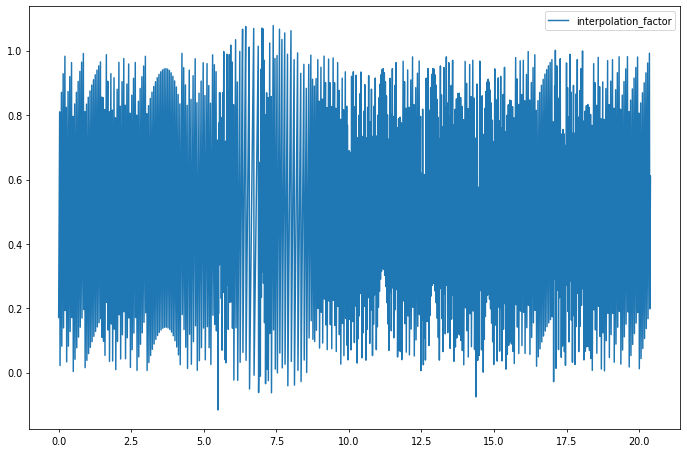

In [8]:


time = make_time(Ts, sim_results['path_x'])

plt.figure(figsize=(12,8), dpi=70)
plt.plot(time, np.rad2deg( sim_results['delta'] ))
plt.plot(time, np.rad2deg( sim_results['delta_dot'] ))
plt.legend(['steering angle (delta)', 'steering rate (delta_dot)'])
plt.show()



#time = make_time(Ts, Delta_l_r_profile)
plt.figure(figsize=(12,8), dpi=70)
plt.plot(time, sim_results['Delta_l_closest_path_sample'], 'g')
plt.plot(time, Delta_l_r_profile)
plt.plot(time, sim_results['Delta_l'])
plt.legend(['Delta_l_closest_path_sample', 'intended lateral distance', 'numerically measured'])
plt.show()



plt.figure(figsize=(12,8), dpi=70)
plt.plot(time, Delta_l_r_profile - sim_results['Delta_l'] )
plt.legend(['residual'])
plt.show()



plt.figure(figsize=(12,8), dpi=70)
plt.plot(time, sim_results['interpolation_factor'] )
plt.legend(['interpolation_factor'])
plt.show()



In [9]:


@ORTDtoNumpy(wheelbase = 3.0, Ts = 0.01, track_data = track_data)
def path_lateral_modification( velocity, Delta_l_r, Delta_l_r_dot, Delta_l_r_dotdot, wheelbase, Ts, track_data ):

    # wheelbase = 3.0
    # sampling time - Ts

    # create storage for the reference path:
    path = import_path_data(track_data)

    # create placeholders for the plant output signals
    x       = dy.signal()
    y       = dy.signal()
    psi     = dy.signal()
    psi_dot = dy.signal()


    results = path_following_controller_P(
        path,
        x, y, psi,
        velocity,
        Delta_l_r        = Delta_l_r,
        Delta_l_r_dot    = Delta_l_r_dot,
        Delta_l_r_dotdot = Delta_l_r_dotdot,
        psi_dot          = psi_dot,
        velocity_dot     = dy.float64(0),
        Ts               = Ts,
        k_p              = 1
    )


    #
    # The model of the vehicle including a disturbance
    #

    # steering angle limit
    limited_steering = dy.saturate(u=results['delta'], lower_limit=-math.pi/2.0, upper_limit=math.pi/2.0)

    # the model of the vehicle
    x_, y_, psi_, x_dot, y_dot, psi_dot_ = discrete_time_bicycle_model(limited_steering, velocity, Ts, wheelbase)

    # driven distance
    d = dy.euler_integrator(velocity, Ts)


    # close the feedback loops
    x       << x_
    y       << y_
    psi     << psi_
    psi_dot << psi_dot_


    #
    output_path = {
        'd'   : d,
        'x'   : x,
        'y'   : y,
        'psi' : psi     + results['delta'],
        'K'   : psi_dot + results['delta_dot']
    }
    
    
    return d, x, y, psi + results['delta'], psi_dot + results['delta_dot'], results['delta'], results['delta_dot']



compiling system tracker_loop (level 1)... 
compiling system simulation (level 0)... 


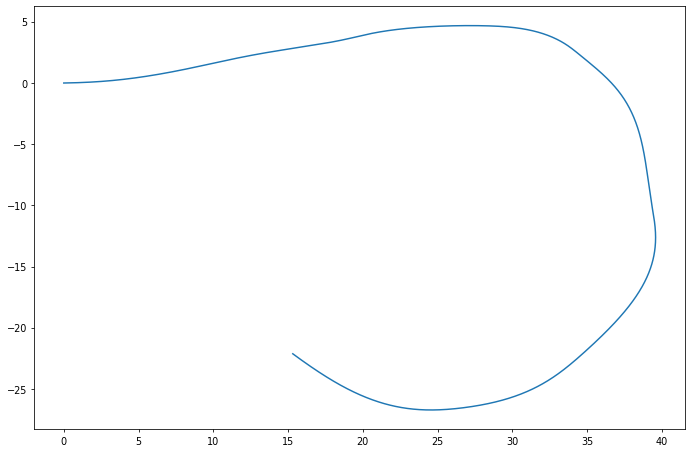

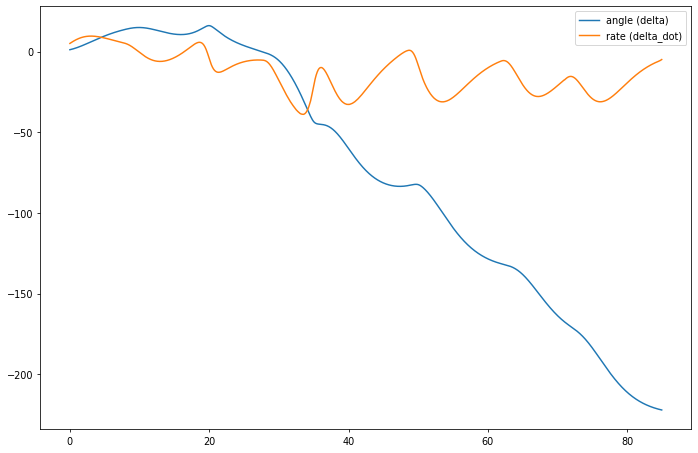

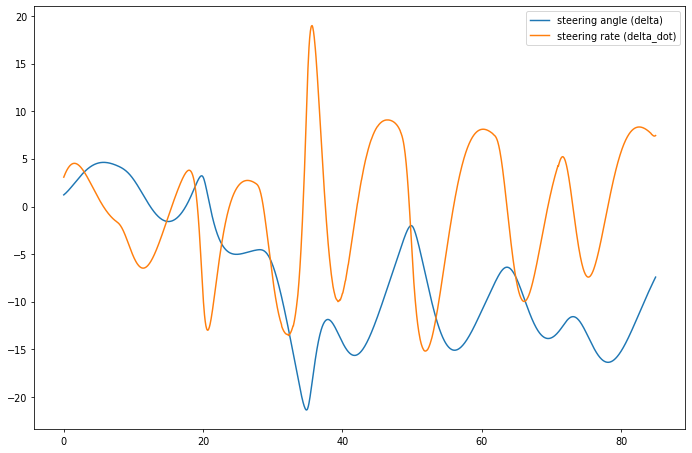

In [10]:


# input_data = {'velocity_': 5.0/scale, 'Delta_l_r': Delta_l_r_profile, 'Delta_l_r_dot': Delta_l_r_dot_profile, 'Delta_l_r_dotdot': Delta_l_r_dotdot_profile}


path_d, path_x, path_y, path_psi, path_psi_dot, path_delta, path_delta_dot = path_lateral_modification( 
    5.0/scale, 
    Delta_l_r_profile, 
    Delta_l_r_dot_profile, 
    Delta_l_r_dotdot_profile
)


path = {}
path['D']           = path_d
path['X']           = path_x
path['Y']           = path_y
path['PSI']         = path_psi
path['K']           = path_psi_dot
path['DELTA']       = path_delta
path['DELTA_DOT']   = path_delta_dot


    
plot_path(path)

In [11]:

def process_data( path, input_signals ):
    
    
    Ts, wheelbase, velocity, Delta_l_r, Delta_l_r_dot, Delta_l_r_dotdot = input_signals
    
    op = path_lateral_modification2(Ts, wheelbase, path, velocity, Delta_l_r, Delta_l_r_dot, Delta_l_r_dotdot)

    
    output_signals2 = ( op['d'], op['x'], op['y'], op['psi'], op['K'], op['d_star'], op['tracked_index'] )

    # print('op', output_signals2)

    current_distance = op['d_star'].set_name('d_star')
    tracked_index    = op['tracked_index']
    read_position         = tracked_index + 1
    minimal_read_position = read_position - 100

    output_signals1 = (read_position, minimal_read_position)

    # print('op1', output_signals1)

    # print( (*output_signals1, *output_signals2) )

    return (*output_signals1, *output_signals2)
    

def async_path_data_handler(async_input_data_valid, path_sample, process_fn, input_signals):
    
    samples_in_buffer = 10000
        
    # allocate the buffers to collect the input data
    path = create_path_horizon( samples_in_buffer )

    
    # feedback variables
    current_read_position  = dy.signal()
    current_distance       = dy.signal()
    elements_free_to_write = dy.signal()
    
    
    # write new data into the buffer as valid samples arrive 
    with dy.sub_if(async_input_data_valid) as system:
        
        append_to_path_horizon(path, path_sample)

        #rb.append_to_buffer(reference['time'],   reference_trajectory_time)
        #rb.append_to_buffer(reference['values'], reference_trajectory_value)

        
    #
    # compute the amount of data available ahead
    #
    
    # the length of the horizonat  
    required_distance_ahead = 30.0   # TODO: dep. on velocity

    head_index, distance_at_the_end_of_horizon = path_horizon_head_index(path) # rb.get_current_absolute_write_index(path['d']) - 1
        
    #
    #distance_at_the_end_of_horizon = rb.read_from_absolute_index(reference['time'], head_index)
    distance_ahead = distance_at_the_end_of_horizon - current_distance
    
    
    #
    # state machine to determine if more data is required
    #
    with dy.sub_statemachine( "sync_control", immediate_state_switch=True ) as switch:

        with switch.new_subsystem('wait_for_more_data') as system:
            
            # the confition for a sufficient amount of data
            sufficient_amount_of_data = distance_ahead >= required_distance_ahead
            
            sync_control = dy.int32(-2) # ask for more data

            next_state = dy.conditional_overwrite(signal=dy.int32(-1), condition=sufficient_amount_of_data, new_value=1 )
            system.set_switched_outputs([ sync_control ], next_state)
            
    
        with switch.new_subsystem('process_data') as system:
            
            # the condition for low amount of data
            low_amount_of_data = distance_ahead < required_distance_ahead
            buffer_overflow    = elements_free_to_write <= 0
            
            sync_control = dy.int32(-1) # run control and yield valid control commands
                    
            next_state = dy.conditional_overwrite(signal=dy.int32(-1), condition=low_amount_of_data, new_value=0 )
            next_state = dy.conditional_overwrite(signal=next_state,   condition=buffer_overflow,    new_value=2 ) # error
            system.set_switched_outputs([ sync_control ], next_state)


        with switch.new_subsystem('error') as system:
            # This is an error state that is entered when a buffer overflow happens,
            # i.e., when input data is passed though no more free space is available
            # in the circular buffer.
            
            sync_control = dy.int32(-3) # error code
            system.set_switched_outputs([ sync_control ], dy.int32(-1) )

    
    sync_control = switch.outputs[0]

    
    #
    # Execute the data processing system in case vaild reference data is 
    # available. Otherwise the output variables are undefined and shall be 
    # discarded by the system in which this schematic is embedded into.
    #
    
    with dy.sub_if(sync_control == -1, subsystem_name='controller') as system:
        
        # perform the interpolation
        interpolation_results = process_fn(path, input_signals)
        
        #
        # Run a control system (feel free to add / implement whatever you like here)
        #
        #    control_variable = controller( interpolation_results, ... )
        #
        
        # return the results / control commands
        system.set_outputs([ *interpolation_results ])


    current_distance       << system.outputs[7] # d_star
    current_read_position  << system.outputs[0]
    minimal_read_position  =  system.outputs[1]
#    os                     =  system.outputs[3]
    
 #   output_signals2 = ( op['d'], op['x'], op['y'], op['psi'], op['K'], op['d_star'], op['tracked_index'] )
    
    output_signals = {}
    output_signals['d'] = system.outputs[2].set_name('d')
    output_signals['x'] = system.outputs[3].set_name('x')
    output_signals['y'] = system.outputs[4].set_name('y')
    output_signals['psi'] = system.outputs[5].set_name('psi')
    output_signals['K'] = system.outputs[6].set_name('K')
    output_signals['d_star'] = system.outputs[7]
    output_signals['tracked_index'] = system.outputs[8]

    # compute the number of elements in the circular buffer that are free to write
    elements_free_to_write << samples_in_buffer - ( head_index - minimal_read_position + 1 )

    
    return sync_control, current_distance, distance_at_the_end_of_horizon, distance_ahead, head_index, current_read_position, elements_free_to_write, output_signals


In [12]:
dy.clear()
system = dy.enter_system()

velocity               = dy.system_input( dy.DataTypeFloat64(1), name='velocity_',         default_value=1,      value_range=[0, 25],   title="vehicle velocity")
Delta_l_r              = dy.system_input( dy.DataTypeFloat64(1), name='Delta_l_r',         default_value=0.0,    value_range=[-10, 10], title="lateral deviation to the path")
Delta_l_r_dot          = dy.system_input( dy.DataTypeFloat64(1), name='Delta_l_r_dot',     default_value=0.0,    value_range=[-10, 10], title="1st-order time derivative of lateral deviation to the path")
Delta_l_r_dotdot       = dy.system_input( dy.DataTypeFloat64(1), name='Delta_l_r_dotdot',  default_value=0.0,    value_range=[-10, 10], title="2nd-order time derivative of lateral deviation to the path")


async_input_data_valid = dy.system_input( dy.DataTypeBoolean(1), name='async_input_data_valid')

path_sample = {}
path_sample['d']   = dy.system_input( dy.DataTypeFloat64(1), name='d_sample')
path_sample['x']   = dy.system_input( dy.DataTypeFloat64(1), name='x_sample')
path_sample['y']   = dy.system_input( dy.DataTypeFloat64(1), name='y_sample')
path_sample['psi'] = dy.system_input( dy.DataTypeFloat64(1), name='psi_sample')
path_sample['K']   = dy.system_input( dy.DataTypeFloat64(1), name='K_sample')







# parameters
wheelbase = 3.0

# sampling time
Ts = 0.01

# create storage for the reference path:
#path = import_path_data(track_data)

input_signals = Ts, wheelbase, velocity, Delta_l_r, Delta_l_r_dot, Delta_l_r_dotdot


sync_control, current_distance, distance_at_the_end_of_horizon, distance_ahead, head_index, current_read_position, elements_free_to_write, output_signals = async_path_data_handler(
    async_input_data_valid, 
    path_sample, 
    process_data, 
    input_signals
)


output_path = output_signals

# output_path = path_lateral_modification2(Ts, wheelbase, path, velocity, Delta_l_r, Delta_l_r_dot, Delta_l_r_dotdot)



#
# outputs: these are available for visualization in the html set-up
#


dy.append_output(sync_control, 'sync_control')
#dy.append_output(current_distance, 'current_distance')
dy.append_output(distance_at_the_end_of_horizon, 'distance_at_the_end_of_horizon')
dy.append_output(distance_ahead, 'distance_ahead')
dy.append_output(head_index, 'head_index')
dy.append_output(current_read_position, 'current_read_position')
dy.append_output(elements_free_to_write, 'elements_free_to_write')


dy.append_output(output_path['tracked_index'], 'tracked_index')
dy.append_output(output_path['d_star'], 'path_d_star')

dy.append_output(output_path['d'], 'path_d')
dy.append_output(output_path['x'], 'path_x')
dy.append_output(output_path['y'], 'path_y')
dy.append_output(output_path['psi'], 'path_psi')
dy.append_output(output_path['K'], 'path_K')

dy.append_output(velocity*dy.float64(1.0), 'velocity')


# generate code for Web Assembly (wasm), requires emcc (emscripten) to build
code_gen_results = dy.generate_code(template=dy.TargetWasm(enable_tracing=False), folder="generated/tmp1", build=False)




compiling system Subsystem1000 (level 1)... 
compiling system Subsystem1001_wait_for_more_data (level 1)... 
compiling system Subsystem1002_process_data (level 1)... 
compiling system Subsystem1003_error (level 1)... 
compiling system tracker_loop (level 2)... 
compiling system controller (level 1)... 
compiling system simulation (level 0)... 
Generated code will be written to generated/tmp1 .


In [13]:
compiled_system = dyexe.CompiledCode(code_gen_results)

In [14]:
#
# In this example loop, the c++ step function of the generated code is called from within python (c++ code wrapped
# by cppyy).
#
# The prototype of the step function is
# 
#    // main step function 
#    void step(Outputs & outputs, Inputs const & inputs, int calculate_outputs, bool update_states, bool reset_states)
#
# and combines the functions 'system reset', 'update states', and the computation of the output signals.
# They can be triggered by the respective flags.
#
# path = import_path_data(track_data)

#
def get_next_input_sample(path):

    k_input = get_next_input_sample.cnt
    
    d, x, y, psi, K = math.nan, math.nan, math.nan, math.nan, math.nan
    
    if k_input < len(path['D']):
        reached_end = False
        
        d   = path['D'][ k_input ]
        x   = path['X'][ k_input ]
        y   = path['Y'][ k_input ]
        psi = path['PSI'][ k_input ]
        K   = path['K'][ k_input ]

        get_next_input_sample.cnt += 1
        
    else:
        reached_end = True

    return reached_end, d, x, y, psi, K

get_next_input_sample.cnt = 0




# Create an instance of the system (this is an instance of the c++ class wrapped by cppyy)
raw_cpp_instance = compiled_system.system_class()

# create data strutures to store I/O data
input_data  = compiled_system.system_class.Inputs()
output_data = compiled_system.system_class.Outputs()

# simulate n steps
n = len(Delta_l_r_profile)-1 #4000

n = 1000

# storage for the output data
path = {}
path['D']   = math.nan * np.zeros(n)
path['X']   = math.nan * np.zeros(n)
path['Y']   = math.nan * np.zeros(n)
path['PSI'] = math.nan * np.zeros(n)
path['K']   = math.nan * np.zeros(n)

path['D_STAR']   = math.nan * np.zeros(n)


sync_control  = [] #math.nan * np.zeros(n)
#current_distance  = [] #math.nan * np.zeros(n)
distance_at_the_end_of_horizon  = [] #math.nan * np.zeros(n)
distance_ahead  = [] #math.nan * np.zeros(n)
head_index  = [] #math.nan * np.zeros(n)
current_read_position  = [] #math.nan * np.zeros(n)
elements_free_to_write  = [] #math.nan * np.zeros(n)

tracked_index = []


real_world_sample_index = 0

# reset the states of the system
raw_cpp_instance.step(output_data, input_data, False, False, True)

# simulate a real time environment with regular sampling
require_next_sample = False

for i in range( 0, n ):

    #
    # simulate a component that generates the asynchronous input data
    #
    # Here, pre-defined data is used.
    #
    # Put your data-generating algorithm here...
    #
    
    input_data.velocity_        = 5
    input_data.Delta_l_r        = Delta_l_r_profile[i]
    input_data.Delta_l_r_dot    = Delta_l_r_dot_profile[i]
    input_data.Delta_l_r_dotdot = Delta_l_r_dotdot_profile[i]
    
    while True:
    
        if require_next_sample:
            # print('passing next input sample at simulation step', i)

            reached_end, d, x, y, psi, K = get_next_input_sample(track_data)

            if reached_end:
                break

            input_data.d_sample    = d
            input_data.x_sample    = x
            input_data.y_sample    = y
            input_data.psi_sample  = psi
            input_data.K_sample    = K

            # if true, a new sample of input data (t, v) is transmitted to the interpolator
            input_data.async_input_data_valid     = True

            # just put one sample and wait until the next one is requested
            require_next_sample = False
        else:

            input_data.async_input_data_valid     = False


        # output computation (writes results into output_data)
        #
        # Please note: it is important that this step is performed *before*
        # updating the states.
        raw_cpp_instance.step(output_data, input_data, True, False, False)

        # update (does not change output_data)
        raw_cpp_instance.step(output_data, input_data, False, True, False)

        # watch out to not cause an buffer overflow by passing too much data that cannot be
        # consumed in time! (not checked here)
        if output_data.elements_free_to_write < 10:
            1
            raise BaseException('..')
            # print('error')

        # print('output_data.sync_control', output_data.sync_control)


        
        sync_control.append( output_data.sync_control )
        #current_distance.append( output_data.current_distance )
        distance_at_the_end_of_horizon.append( output_data.distance_at_the_end_of_horizon )
        distance_ahead.append( output_data.distance_ahead )
        head_index.append( output_data.head_index  )
        current_read_position.append( output_data.current_read_position )
        elements_free_to_write.append( output_data.elements_free_to_write )
        
        tracked_index.append( output_data.tracked_index )
        


        if output_data.sync_control == -2:
            #
            # The interpolator came to the point at which it urgently needs more
            # input data. Hence, the data-generating algorithm (above) is required
            # to produce new data.
            #

            require_next_sample = True
            
            continue

        if output_data.sync_control == -1:
            #print('.')
            
            break
            

    if output_data.sync_control == -3:
        print('internal error')

        break

        
    # The interpolation results are valid so store them or apply to something (e.g., sending to an actuator)

    path['D'][real_world_sample_index]     = output_data.path_d
    path['X'][real_world_sample_index]     = output_data.path_x
    path['Y'][real_world_sample_index]     = output_data.path_y
    path['PSI'][real_world_sample_index]   = output_data.path_psi
    path['K'][real_world_sample_index]     = output_data.path_K
    
    path['D_STAR'][real_world_sample_index]     = output_data.path_d_star
    

    real_world_sample_index += 1
    

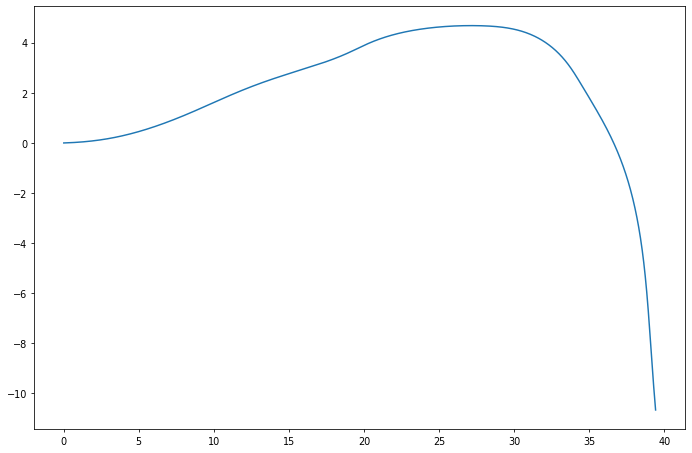

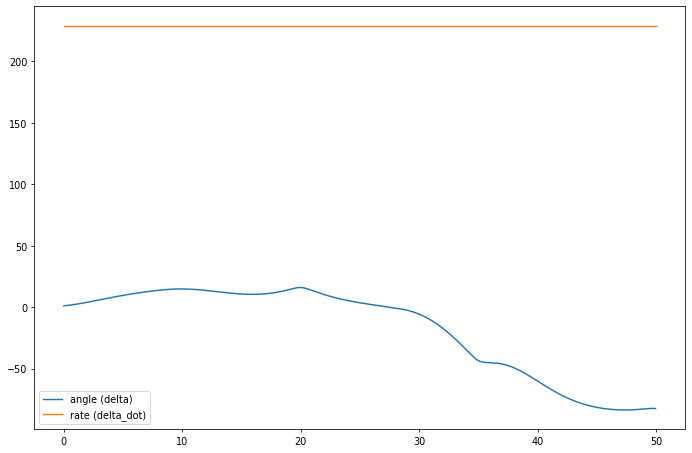

In [15]:
plot_path(path)

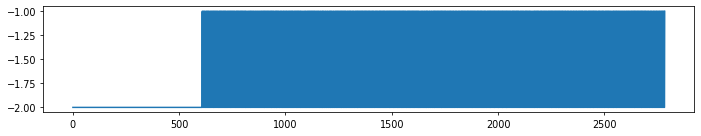

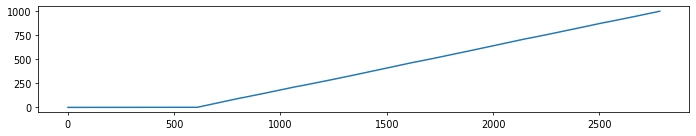

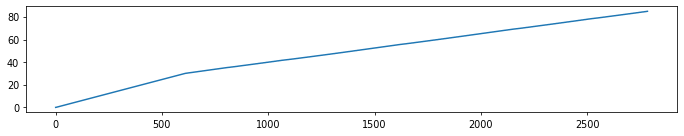

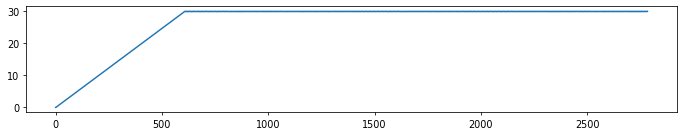

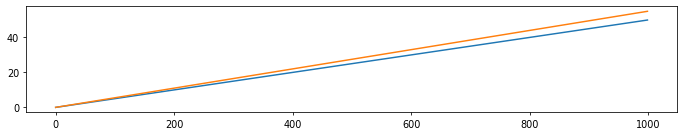

In [16]:
plt.figure(figsize=(12,2), dpi=70)
plt.plot( sync_control )
plt.show()

plt.figure(figsize=(12,2), dpi=70)
plt.plot( tracked_index )
plt.show()



plt.figure(figsize=(12,2), dpi=70)
plt.plot( distance_at_the_end_of_horizon )
plt.show()


plt.figure(figsize=(12,2), dpi=70)
plt.plot( distance_ahead )
plt.show()

plt.figure(figsize=(12,2), dpi=70)
plt.plot( path['D'] )
plt.plot( path['D_STAR'] )
plt.show()

In [17]:
#tracked_index

In [18]:
len(track_data['X'])

2725

In [19]:
len(  path['X'] )

1000

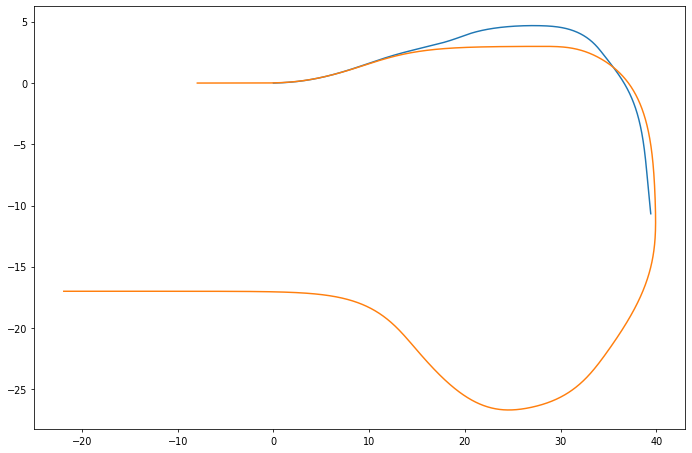

In [20]:
plt.figure(figsize=(12,8), dpi=70)
plt.plot( path['X'], path['Y'] )
plt.plot( track_data['X'], track_data['Y'] )

plt.show()